In [1]:
import torch
import os
from d2l import torch as d2l

下载数据集，数据集中的每一行都是制表符分隔的文本序列对， 序列对由英文文本序列和翻译后的法语文本序列组成。 请注意，每个文本序列可以是一个句子， 也可以是包含多个句子的一个段落。 在这个将英语翻译成法语的机器翻译问题中， 英语是源语言（source language）， 法语是目标语言（target language）。

In [2]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

raw_txt = read_data()
print(raw_txt[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



对数据集进行预处理

In [3]:
def preprocess(text):
    # 将标点符号分离出来
    def no_space(char, prev_char):
        return char in set (',.!?') and prev_char != ' '
    
    # 将不连续空格替换成空格，将大写换成小写
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    
    # 在标点符号前面添加空格
    out = [' '+ char if i>0 and no_space(char, text[i-1]) else char for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess(raw_txt)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


词元化

In [4]:
def tokenize(text, num_examples=None):
    # 构造源词元表和目标词元表
    source, target = [], []
    # 先按照行进行分离
    for i, line in enumerate(text.split('\n')):
        # 判断是否超出范围
        if num_examples and i>num_examples:
            break
        # 按分隔间距进行分词
        parts = line.split('\t')
        # 若长度为2则说明里面仅包含一个英语词和一个法语词，按对压入源词元表和目标词元表
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

src, tar = tokenize(text)
src[:6], tar[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

画出每个文本序列含有多少词元

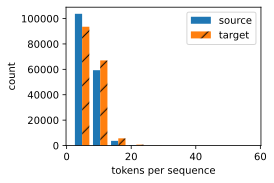

In [7]:
def show_tokens_per_seq(legend, xlabel, ylabel, xlist, ylist):
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_tokens_per_seq(['source', 'target'], 'tokens per sequence', 'count', src, tar)

构造一个源语言的词汇表

In [41]:
src_vocab1 = d2l.Vocab(src, min_freq = 2, reserved_tokens = ['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

构造一个函数能在序列中制造小批量数据：给定一个时间步长num_steps，一个小批量数据内的每个序列的长度都应该为num_steps。若一个序列的的长度大于num_steps，就应该截取前num_steps个词元组成序列；若一个序列的长度小于num_steps，则应该在其尾部补充词元数量直至满足num_steps的长度。

In [37]:
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        line = line[:num_steps]
    else:
        line = line + [padding_token] * (num_steps - len(line))
    return line

truncate_pad(src_vocab[src[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [43]:
def array_build(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [44]:
def load_data(batch_size, num_steps, num_examples=600):
    # 文本序列预处理
    text = preprocess(read_data())
    # 词元化
    source, target = tokenize(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens = ['<pad>', '<bos>', '<eos>'])
    tar_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens = ['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = array_build(source, src_vocab, num_steps)
    tar_array, tar_valid_len = array_build(target, tar_vocab, num_steps)
    data_array = (src_array, src_valid_len, tar_array, tar_valid_len)
    data_iter = d2l.load_array(data_array, batch_size)
    return src_vocab, tar_vocab, data_iter

In [45]:
src_vocab, tar_vocab, train_iter = load_data(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[10, 73,  4,  3,  1,  1,  1,  1],
        [14, 27,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[ 8,  0,  4,  3,  1,  1,  1,  1],
        [26, 58,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([4, 4])
